In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,classification_report
from imblearn.over_sampling import *
from sklearn.svm import SVC
from matplotlib import pyplot as plt

In [3]:
df=pd.read_csv('complete_data.csv')
df.head(5)

,s1,s2,s3,s4,s5,s6,s8,hour,group
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,2.0,4.0,3.0,1.0,1.0,0.0,0.1,0,0
2,4.0,6.0,-5.0,0.0,1.0,-1.0,0.1,0,0
3,7.0,10.0,4.0,3.0,1.0,7.0,0.0,0,0
4,13.0,13.0,8.0,7.0,2.0,19.0,0.0,0,0


In [4]:
#first take 12 unit average window in each hour and group, because there are 12 values in each minute

In [5]:
# df_list=[]
# for i in range(0,len(df),12):
#     df_list.append(df.iloc[i:i+12].mean())
# df_new=pd.concat(df_list,1).T    
df=df.groupby(df.index//12*5).mean()


In [6]:
df.hour=df.hour.round()
df.group=df.group.round()

In [7]:
# df.drop('s8',axis=1,inplace=True)
# df.head()


In [8]:
dfs=[]
for i in df.group.unique():
    dfs.append(df[df['group']==i][1:-1])#just remove some rows from end of each group
    

In [9]:
df=pd.concat(dfs)
df

,s1,s2,s3,s4,s5,s6,s8,hour,group
5,39.750000,33.333333,29.000000,22.916667,10.000000,42.250000,0.516667,0.0,0.0
10,47.083333,43.000000,38.916667,29.833333,14.583333,49.416667,0.841667,0.0,0.0
15,52.416667,48.833333,47.833333,34.000000,17.666667,53.166667,1.025000,0.0,0.0
20,56.583333,52.416667,55.333333,37.166667,19.416667,54.916667,1.200000,0.0,0.0
25,57.583333,52.166667,58.000000,39.333333,20.750000,55.916667,1.391667,0.0,0.0
...,...,...,...,...,...,...,...,...,...
90940,602.166667,626.250000,589.000000,682.083333,469.000000,848.250000,0.750000,13.0,14.0
90945,602.666667,626.000000,589.000000,681.416667,469.833333,848.000000,0.808333,13.0,14.0
90950,602.250000,625.916667,589.083333,681.000000,469.916667,848.000000,0.800000,13.0,14.0
90955,602.666667,626.666667,589.000000,681.833333,470.083333,848.083333,0.800000,13.0,14.0


In [10]:
cols=['mq135','mq2','mq3','mq6','mq7','mq9','humid']


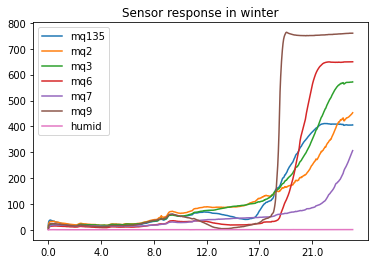

In [11]:

day1=df[df.group==3].iloc[:,0:-2].values
hours=df[df.group==3]['hour'].values
plt.plot(day1,label=cols);
plt.legend()
plt.xticks(range(0,len(hours)),hours)
plt.xticks(np.arange(0, len(hours)+1, 250))
plt.title('Sensor response in winter')
plt.show()


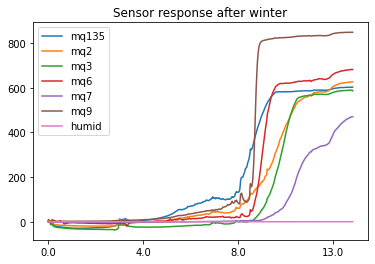

In [12]:

day1=df[df.group==14].iloc[:,0:-2].values
hours=df[df.group==14]['hour'].values
plt.plot(day1,label=cols);
plt.legend()
plt.xticks(range(0,len(hours)),hours)
plt.xticks(np.arange(0, len(hours)+1, 250))
plt.title('Sensor response after winter')
plt.show()


In [13]:
gh=df.groupby('group')['hour'].max().reset_index()
gh.head()

,group,hour
0,0.0,27.0
1,1.0,24.0
2,2.0,26.0
3,3.0,24.0
4,4.0,24.0


In [14]:
gh[gh['hour']>15]['group'].to_list()

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 11.0]

In [15]:
df.reset_index(drop=True,inplace=True)

In [16]:
#separate all groups with hour greater than 15
df1=df[df['group'].isin(gh[gh['hour']>15]['group'].to_list())]
df2=df[df['group'].isin(gh[gh['hour']<=15]['group'].to_list())]

In [17]:
def getXY(df,l1,l2):
    X=df.iloc[:,0:-2].values
    y=df.iloc[:,-2].values
    y=np.where(( y>0) & (y<=l1), 0, y)
    y=np.where(( y>l1) & (y<=l2), 1, y)
    y=np.where(y >l2,2,y)
    groups=df.iloc[:,-1].values
    return X,y,groups

In [18]:
X1,y1,g1=getXY(df1,8,16)
X2,y2,g2=getXY(df2,5,10)
X=np.concatenate((X1,X2))
y=np.concatenate((y1,y2))
groups=np.concatenate((g1,g2))

# EDA

In [19]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 6736, 1.0: 6281, 2.0: 5147}


In [20]:
stat_df=pd.concat((pd.DataFrame(X),pd.DataFrame(y)),axis=1)
stat_df.columns=['mq135','mq2','mq3','mq6','mq7','mq9','humidity','label']
stat_df.head()

,mq135,mq2,mq3,mq6,mq7,mq9,humidity,label
0,39.750000,33.333333,29.000000,22.916667,10.000000,42.250000,0.516667,0.0
1,47.083333,43.000000,38.916667,29.833333,14.583333,49.416667,0.841667,0.0
2,52.416667,48.833333,47.833333,34.000000,17.666667,53.166667,1.025000,0.0
3,56.583333,52.416667,55.333333,37.166667,19.416667,54.916667,1.200000,0.0
4,57.583333,52.166667,58.000000,39.333333,20.750000,55.916667,1.391667,0.0


In [21]:
stat_dfx=stat_df.groupby('label').describe().unstack(1).reset_index()
stat_dfx.label=stat_dfx.label.map({0:'Fresh',1:"Semi-Fresh",2:"Spoiled"})

stat_dfx

,level_0,level_1,label,0
0,mq135,count,Fresh,6736.000000
1,mq135,count,Semi-Fresh,6281.000000
2,mq135,count,Spoiled,5147.000000
3,mq135,mean,Fresh,40.804582
4,mq135,mean,Semi-Fresh,238.739413
...,...,...,...,...
163,humidity,75%,Semi-Fresh,0.700000
164,humidity,75%,Spoiled,0.891667
165,humidity,max,Fresh,3.441667
166,humidity,max,Semi-Fresh,3.441667


In [22]:
stat_dfx[stat_dfx['level_0']=='humidity']

,level_0,level_1,label,0
144,humidity,count,Fresh,6736.000000
145,humidity,count,Semi-Fresh,6281.000000
146,humidity,count,Spoiled,5147.000000
147,humidity,mean,Fresh,0.358304
148,humidity,mean,Semi-Fresh,0.473087
149,humidity,mean,Spoiled,0.589159
150,humidity,std,Fresh,0.871932
151,humidity,std,Semi-Fresh,0.953047
152,humidity,std,Spoiled,1.126042
153,humidity,min,Fresh,-1.075000


In [23]:
stat_dfx.level_1.value_counts()

count    21
mean     21
std      21
min      21
25%      21
50%      21
75%      21
max      21
Name: level_1, dtype: int64

# Stat Analysis

/tmp/ipykernel_69718/967936176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_df.drop(['stat'],axis=1,inplace=True)
/tmp/ipykernel_69718/967936176.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_df['mean']=mean_df['mean'].round(0).astype(int)


Text(0.5, 1.0, 'MQ Gas sensors average response in all three classes')

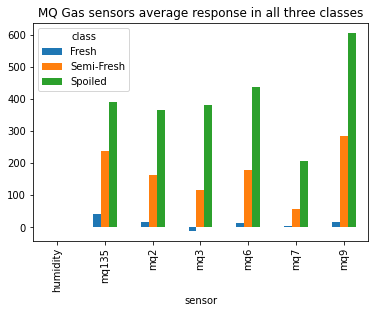

In [24]:
mean_df=stat_dfx[stat_dfx.level_1.isin(['mean'])]
mean_df.columns=['sensor','stat','class','mean']
mean_df.drop(['stat'],axis=1,inplace=True)
mean_df['mean']=mean_df['mean'].round(0).astype(int)
mean_df.reset_index(inplace=True,drop=True)

(mean_df.groupby(['sensor', 'class'])['mean'].sum()
 .unstack()
 .plot(kind='bar', stacked=False))
plt.title("MQ Gas sensors average response in all three classes")

In [25]:
from scipy.stats import f_oneway
for c in list(stat_df.columns)[0:-1]:
    res=f_oneway(stat_df[stat_df['label']==0][c], stat_df[stat_df['label']==1][c], stat_df[stat_df['label']==2][c])
    print(res)

F_onewayResult(statistic=6625.783548892957, pvalue=0.0)
F_onewayResult(statistic=8475.58343144917, pvalue=0.0)
F_onewayResult(statistic=12153.772742865416, pvalue=0.0)
F_onewayResult(statistic=6137.344618001988, pvalue=0.0)
F_onewayResult(statistic=4472.0300679272905, pvalue=0.0)
F_onewayResult(statistic=7260.235498387436, pvalue=0.0)
F_onewayResult(statistic=81.85334871252935, pvalue=4.0813723994766896e-36)


In [26]:
stat_df.columns

Index(['mq135', 'mq2', 'mq3', 'mq6', 'mq7', 'mq9', 'humidity', 'label'], dtype='object')

In [27]:
from statsmodels.multivariate.manova import MANOVA
maov = MANOVA.from_formula('mq135 + mq2 + mq3+\
                            mq6 + mq7  +mq9 ~ label', data=stat_df)
print(maov.mv_test())

                    Multivariate linear model
                                                                 
-----------------------------------------------------------------
        Intercept        Value  Num DF   Den DF   F Value  Pr > F
-----------------------------------------------------------------
           Wilks' lambda 0.7814 6.0000 18157.0000 846.3608 0.0000
          Pillai's trace 0.2186 6.0000 18157.0000 846.3608 0.0000
  Hotelling-Lawley trace 0.2797 6.0000 18157.0000 846.3608 0.0000
     Roy's greatest root 0.2797 6.0000 18157.0000 846.3608 0.0000
-----------------------------------------------------------------
                                                                 
-----------------------------------------------------------------
         label          Value  Num DF   Den DF    F Value  Pr > F
-----------------------------------------------------------------
          Wilks' lambda 0.4122 6.0000 18157.0000 4315.7078 0.0000
         Pillai's trace 0.5878

# Machine learning 

In [28]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,\
cross_validate,cross_val_score,KFold,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer,roc_auc_score
from sklearn.decomposition import PCA
scoring=[ 'precision_macro','recall_macro','f1_macro','accuracy']


## Random Split

In [29]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [30]:
X.shape

(18164, 7)

In [31]:
clf=SVC(random_state=0)

scaling=StandardScaler()
pipe = Pipeline(steps=[('sc',scaling), ('clf', clf)])
pipe.fit(X_train,y_train)
pred=pipe.predict(X_test)

In [32]:
pred

array([0., 0., 1., ..., 2., 1., 1.])

In [33]:
print(classification_report(y_test,pred,target_names=['Fresh','SemiFresh','Spoiled']))

              precision    recall  f1-score   support

       Fresh       0.92      0.92      0.92      1358
   SemiFresh       0.82      0.87      0.84      1262
     Spoiled       0.94      0.87      0.90      1013

    accuracy                           0.89      3633
   macro avg       0.89      0.89      0.89      3633
weighted avg       0.89      0.89      0.89      3633



In [34]:
for train, test in StratifiedKFold(5,shuffle=True).split(X,y):
    X_train,X_test=X[train],X[test]
    y_train,y_test=y[train],y[test]
    clf=SVC()
    scaling=StandardScaler()
    pipe = Pipeline(steps=[('sc',scaling), ('clf', clf)])
    pipe.fit(X_train,y_train)
    pred=pipe.predict(X_test)
    print(classification_report(pred,y_test,target_names=['Fresh','SemiFresh','Spoiled']))

              precision    recall  f1-score   support

       Fresh       0.94      0.91      0.92      1392
   SemiFresh       0.86      0.85      0.85      1263
     Spoiled       0.90      0.95      0.92       978

    accuracy                           0.90      3633
   macro avg       0.90      0.90      0.90      3633
weighted avg       0.90      0.90      0.90      3633

              precision    recall  f1-score   support

       Fresh       0.91      0.91      0.91      1344
   SemiFresh       0.86      0.81      0.84      1325
     Spoiled       0.88      0.94      0.91       964

    accuracy                           0.88      3633
   macro avg       0.88      0.89      0.89      3633
weighted avg       0.88      0.88      0.88      3633

              precision    recall  f1-score   support

       Fresh       0.93      0.92      0.92      1353
   SemiFresh       0.89      0.83      0.86      1339
     Spoiled       0.88      0.96      0.92       941

    accuracy        

In [35]:
pipe = Pipeline(steps=[('sc',scaling), ('clf', clf)])
cv=cross_validate(pipe,X,y,cv=5,n_jobs=-1)
# mean=[np.mean(cv[i]).round(2) for i in cv][2::]
# std=[np.std(cv[i]).round(2) for i in cv][2::]
# mean,std

In [36]:
cross_val_score(pipe,X,y,cv=5)

array([0.49408203, 0.62730526, 0.78062208, 0.552436  , 0.79680617])

# Baseline

# Baseline

In [37]:
%%time
clf= SVC(random_state=0)
scaling=StandardScaler()
pipe = Pipeline(steps=[('sc',scaling), ('clf', clf)])
cv=cross_validate(pipe,X,y,groups=groups,cv=GroupKFold(5),n_jobs=-1,scoring=scoring)
cv

CPU times: user 9.59 ms, sys: 1.08 ms, total: 10.7 ms
Wall time: 1.84 s


{'fit_time': array([0.94536304, 1.07316065, 0.84240222, 1.1990521 , 1.16665506]),
 'score_time': array([0.37647271, 0.42637658, 0.34174871, 0.47695088, 0.47294068]),
 'test_precision_macro': array([0.70073638, 0.7346931 , 0.6445179 , 0.74856601, 0.67689096]),
 'test_recall_macro': array([0.68718622, 0.64665508, 0.48645484, 0.73561172, 0.64035598]),
 'test_f1_macro': array([0.66787937, 0.6124812 , 0.44393656, 0.70597856, 0.65066553]),
 'test_accuracy': array([0.66216216, 0.61824231, 0.50881057, 0.73571622, 0.64592391])}

In [38]:
results=[]

In [39]:
mean=[np.mean(cv[i]).round(3) for i in cv][2::]
std=[np.std(cv[i]).round(3) for i in cv][2::]
mean,std

([0.701, 0.639, 0.616, 0.634], [0.038, 0.084, 0.091, 0.074])

In [41]:

clf=SVC()
scaling=StandardScaler()
Cs = [ 0.1, 1, 10,15,20,25,30,40,50,60,70,100,120]
gammas = [0.0001,0.0005,0.001,0.005,0.008, 0.01, 0.1,0.3,0.5, 1]
param_grid = {'clf__C': Cs, 'clf__gamma' : gammas}

pipe = Pipeline(steps=[('sc',scaling), ('clf', clf)])
grid_search =GridSearchCV(pipe , param_grid,  cv=GroupKFold(5),n_jobs=-1,scoring=scoring,refit='f1_macro')
grid_search.fit(X,y,groups=groups)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'clf__C': 50, 'clf__gamma': 0.001}
0.7407020077873445


In [42]:
pipe = grid_search.best_estimator_
cv=cross_validate(pipe,X,y,groups=groups,cv=GroupKFold(5),n_jobs=-1,scoring=scoring)
cv

{'fit_time': array([1.28916478, 1.56332064, 1.50862265, 1.65790558, 1.52504396]),
 'score_time': array([0.51965022, 0.56701636, 0.48048139, 0.61084366, 0.59660959]),
 'test_precision_macro': array([0.83504733, 0.78677646, 0.66251599, 0.86811589, 0.80017045]),
 'test_recall_macro': array([0.79678111, 0.75723159, 0.53492853, 0.8503787 , 0.80543827]),
 'test_f1_macro': array([0.79779913, 0.7467523 , 0.50741439, 0.85275478, 0.79878944]),
 'test_accuracy': array([0.78688063, 0.73967286, 0.56084802, 0.85458976, 0.80027174])}

In [43]:
mean=[np.mean(cv[i]).round(3) for i in cv][2::]
std=[np.std(cv[i]).round(3) for i in cv][2::]
mean,std

([0.791, 0.749, 0.741, 0.748], [0.07, 0.111, 0.121, 0.101])

# RFE

In [46]:
%%time
clf=SVC(random_state=0)
rfe=RFE(DecisionTreeClassifier(random_state=0))
scaling=StandardScaler()
n_features = [2,4,6]
step=[1,2,3]
param_grid = {'rfe__step':step,'rfe__n_features_to_select':n_features,
                  'clf__C': Cs, 'clf__gamma' : gammas}

pipe = Pipeline(steps=[('sc',scaling),('rfe', rfe), ('clf', clf)])
grid_search =GridSearchCV(pipe , param_grid,  cv=GroupKFold(5),n_jobs=-1,scoring='f1_macro')
grid_search.fit(X,y,groups=groups)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'clf__C': 1, 'clf__gamma': 0.1, 'rfe__n_features_to_select': 2, 'rfe__step': 1}
0.7722277944316166
CPU times: user 11.7 s, sys: 1.65 s, total: 13.4 s
Wall time: 16min 51s


In [47]:
pipe = grid_search.best_estimator_
cv=cross_validate(pipe,X,y,groups=groups,cv=GroupKFold(5),n_jobs=-1,scoring=scoring)
mean=[np.mean(cv[i]).round(3) for i in cv][2::]
std=[np.std(cv[i]).round(3) for i in cv][2::]
mean,std

([0.822, 0.78, 0.772, 0.785], [0.065, 0.107, 0.113, 0.097])

# PCA

In [48]:
%%time
clf=SVC(random_state=0)

scaling=StandardScaler()
n_components=[2,4,6]

param_grid = {'pca__n_components':n_components,
                  'clf__C': Cs, 'clf__gamma' : gammas}

pipe = Pipeline(steps=[('sc',scaling),('pca', PCA()), ('clf', clf)])
grid_search =GridSearchCV(pipe , param_grid,  cv=GroupKFold(5 ),n_jobs=-1,scoring='f1_macro')
grid_search.fit(X,y,groups=groups)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'clf__C': 60, 'clf__gamma': 0.0001, 'pca__n_components': 6}
0.7276555403596257
CPU times: user 6.28 s, sys: 1.9 s, total: 8.18 s
Wall time: 5min 23s


In [49]:
pipe = grid_search.best_estimator_
cv=cross_validate(pipe,X,y,groups=groups,cv=GroupKFold(5),n_jobs=-1,scoring=scoring)
mean=[np.mean(cv[i]).round(3) for i in cv][2::]
std=[np.std(cv[i]).round(3) for i in cv][2::]
mean,std

([0.779, 0.734, 0.728, 0.735], [0.071, 0.11, 0.12, 0.102])